# CSL7360: Computer Vision - Assignment 3

**Student:** Atharva Date  
**Roll Number:** B22AI045

---

## Setup: Import Libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from scipy.stats import multivariate_normal
import maxflow

print("All libraries imported successfully!")

All libraries imported successfully!


---
# Question 1: Lucas-Kanade Optical Flow

Implementation of Lucas-Kanade optical flow with Harris corner detector from scratch.

## 1.1 Harris Corner Detector Implementation

In [2]:
class HarrisCornerDetector:
    def __init__(self, k=0.04, threshold=0.01, window_size=3):
        self.k = k
        self.threshold = threshold
        self.window_size = window_size
    
    def detect(self, image):
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
        
        gray = gray.astype(np.float32)
        
        Ix = convolve(gray, np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]))
        Iy = convolve(gray, np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]))
        
        Ixx = Ix * Ix
        Iyy = Iy * Iy
        Ixy = Ix * Iy
        
        window = np.ones((self.window_size, self.window_size))
        Sxx = convolve(Ixx, window)
        Syy = convolve(Iyy, window)
        Sxy = convolve(Ixy, window)
        
        det_M = (Sxx * Syy) - (Sxy ** 2)
        trace_M = Sxx + Syy
        R = det_M - self.k * (trace_M ** 2)
        
        corner_threshold = self.threshold * R.max()
        corners = R > corner_threshold
        
        corner_coords = np.argwhere(corners)
        corner_coords = corner_coords[:, [1, 0]]
        
        return corner_coords, R

print("✓ Harris Corner Detector class defined")

✓ Harris Corner Detector class defined


## 1.2 Lucas-Kanade Optical Flow Implementation

In [3]:
class LucasKanadeOpticalFlow:
    def __init__(self, window_size=15):
        self.window_size = window_size
        self.half_window = window_size // 2
    
    def compute_flow(self, img1, img2, points):
        if len(img1.shape) == 3:
            gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        else:
            gray1 = img1
        
        if len(img2.shape) == 3:
            gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        else:
            gray2 = img2
        
        gray1 = gray1.astype(np.float32)
        gray2 = gray2.astype(np.float32)
        
        Ix = convolve(gray1, np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])) / 8.0
        Iy = convolve(gray1, np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])) / 8.0
        It = gray2 - gray1
        
        flows = []
        valid_points = []
        
        for point in points:
            x, y = int(point[0]), int(point[1])
            
            if (x - self.half_window < 0 or x + self.half_window >= gray1.shape[1] or
                y - self.half_window < 0 or y + self.half_window >= gray1.shape[0]):
                continue
            
            patch_Ix = Ix[y - self.half_window:y + self.half_window + 1,
                          x - self.half_window:x + self.half_window + 1].flatten()
            patch_Iy = Iy[y - self.half_window:y + self.half_window + 1,
                          x - self.half_window:x + self.half_window + 1].flatten()
            patch_It = It[y - self.half_window:y + self.half_window + 1,
                          x - self.half_window:x + self.half_window + 1].flatten()
            
            A = np.vstack((patch_Ix, patch_Iy)).T
            b = -patch_It
            
            ATA = A.T @ A
            
            if np.linalg.det(ATA) < 1e-5:
                continue
            
            flow = np.linalg.lstsq(A, b, rcond=None)[0]
            
            flows.append(flow)
            valid_points.append(point)
        
        return np.array(valid_points), np.array(flows)

print("✓ Lucas-Kanade Optical Flow class defined")

✓ Lucas-Kanade Optical Flow class defined


## 1.3 Load Input Frames

✓ Frame 1 loaded: (480, 640, 3)
✓ Frame 2 loaded: (480, 640, 3)


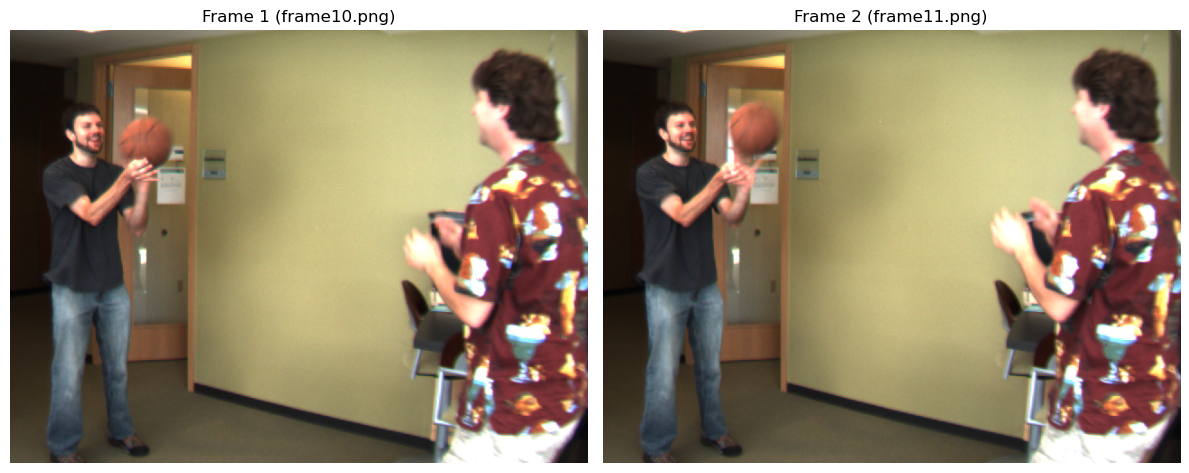

In [4]:
img1 = cv2.imread('images/frame10.png')
img2 = cv2.imread('images/frame11.png')

if img1 is None or img2 is None:
    print("ERROR: Please place frame10.png and frame11.png in the images/ directory")
else:
    print(f"✓ Frame 1 loaded: {img1.shape}")
    print(f"✓ Frame 2 loaded: {img2.shape}")
    
    cv2.imwrite('outputs/frame10.png', img1)
    cv2.imwrite('outputs/frame11.png', img2)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Frame 1 (frame10.png)')
    axes[0].axis('off')
    axes[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Frame 2 (frame11.png)')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

## 1.4 Detect Harris Corners

✓ Detected 232 corners (after subsampling)


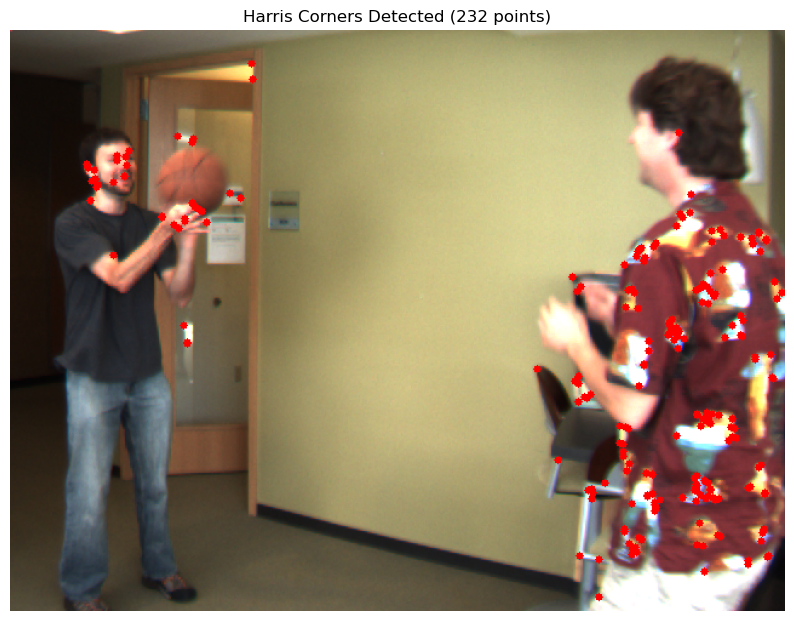

In [5]:
harris = HarrisCornerDetector(k=0.04, threshold=0.01, window_size=3)
corners, response = harris.detect(img1)

corners = corners[::10]

print(f"✓ Detected {len(corners)} corners (after subsampling)")

corner_img = img1.copy()
for corner in corners:
    cv2.circle(corner_img, (int(corner[0]), int(corner[1])), 3, (0, 0, 255), -1)

cv2.imwrite('outputs/harris_corners.jpg', corner_img)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(corner_img, cv2.COLOR_BGR2RGB))
plt.title(f'Harris Corners Detected ({len(corners)} points)')
plt.axis('off')
plt.show()

## 1.5 Compute Optical Flow

In [6]:
lk = LucasKanadeOpticalFlow(window_size=15)
valid_points, flows = lk.compute_flow(img1, img2, corners)

print(f"✓ Successfully tracked {len(valid_points)} points")
print(f"✓ Average flow magnitude: {np.mean(np.linalg.norm(flows, axis=1)):.2f} pixels")

✓ Successfully tracked 230 points
✓ Average flow magnitude: 1.72 pixels


## 1.6 Visualize Optical Flow

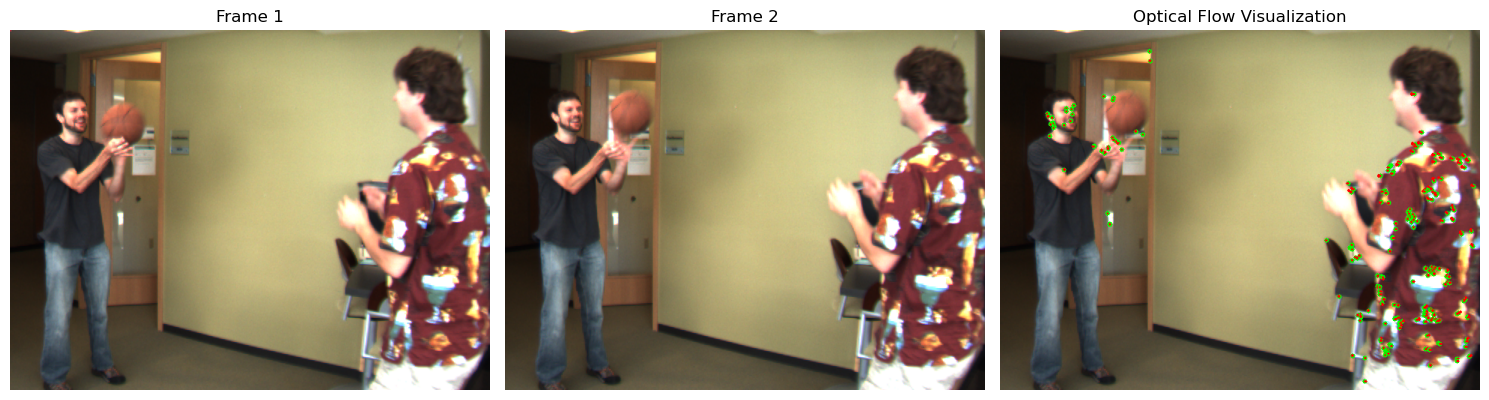

✓ Question 1 completed successfully!


In [7]:
result = img2.copy()

for i, (point, flow) in enumerate(zip(valid_points, flows)):
    x, y = int(point[0]), int(point[1])
    fx, fy = flow
    
    cv2.circle(result, (x, y), 3, (0, 255, 0), -1)
    
    end_x = int(x + fx)
    end_y = int(y + fy)
    cv2.arrowedLine(result, (x, y), (end_x, end_y), (0, 0, 255), 2, tipLength=0.3)

cv2.imwrite('outputs/optical_flow_result.jpg', result)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Frame 1')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Frame 2')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Optical Flow Visualization')
plt.axis('off')

plt.tight_layout()
plt.savefig('outputs/optical_flow_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Question 1 completed successfully!")

---
# Question 2: Graph Cut Segmentation

Implementation of binary segmentation using graph cuts with Gaussian color models.

## 2.1 Graph Cut Segmentation Implementation

In [8]:
class GraphCutSegmentation:
    def __init__(self, image, smoothness_weight=10.0):
        self.image = image.astype(np.float32)
        self.smoothness_weight = smoothness_weight
        self.height, self.width = image.shape[:2]
        self.fg_model = None
        self.bg_model = None
    
    def fit_gaussian_models(self, fg_seeds, bg_seeds):
        fg_pixels = self.image[fg_seeds[:, 1], fg_seeds[:, 0]]
        bg_pixels = self.image[bg_seeds[:, 1], bg_seeds[:, 0]]
        
        self.fg_mean = np.mean(fg_pixels, axis=0)
        self.fg_cov = np.cov(fg_pixels.T) + np.eye(3) * 1e-5
        
        self.bg_mean = np.mean(bg_pixels, axis=0)
        self.bg_cov = np.cov(bg_pixels.T) + np.eye(3) * 1e-5
    
    def compute_data_term(self, pixel):
        fg_prob = multivariate_normal.pdf(pixel, self.fg_mean, self.fg_cov)
        bg_prob = multivariate_normal.pdf(pixel, self.bg_mean, self.bg_cov)
        
        fg_cost = -np.log(fg_prob + 1e-10)
        bg_cost = -np.log(bg_prob + 1e-10)
        
        return fg_cost, bg_cost
    
    def compute_smoothness_term(self, pixel1, pixel2):
        diff = np.linalg.norm(pixel1 - pixel2)
        return self.smoothness_weight * np.exp(-diff / 10.0)
    
    def segment(self, fg_seeds, bg_seeds):
        self.fit_gaussian_models(fg_seeds, bg_seeds)
        
        g = maxflow.Graph[float]()
        nodeids = g.add_grid_nodes((self.height, self.width))
        
        for y in range(self.height):
            for x in range(self.width):
                pixel = self.image[y, x]
                fg_cost, bg_cost = self.compute_data_term(pixel)
                
                g.add_tedge(nodeids[y, x], fg_cost, bg_cost)
        
        for y in range(self.height):
            for x in range(self.width):
                if x < self.width - 1:
                    weight = self.compute_smoothness_term(
                        self.image[y, x], self.image[y, x + 1])
                    g.add_edge(nodeids[y, x], nodeids[y, x + 1], weight, weight)
                
                if y < self.height - 1:
                    weight = self.compute_smoothness_term(
                        self.image[y, x], self.image[y + 1, x])
                    g.add_edge(nodeids[y, x], nodeids[y + 1, x], weight, weight)
        
        g.maxflow()
        
        segmentation = g.get_grid_segments(nodeids)
        
        return segmentation.astype(np.uint8) * 255

print("✓ Graph Cut Segmentation class defined")

✓ Graph Cut Segmentation class defined


## 2.2 Load Input Image and Create Seeds

✓ Bird image loaded: (502, 500, 3)
✓ Foreground seeds: 7
✓ Background seeds: 12


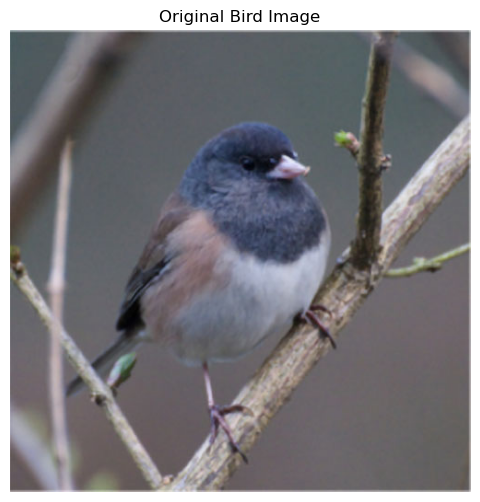

In [9]:
bird_img = cv2.imread('images/bird.jpg')

if bird_img is None:
    print("ERROR: bird.jpg not found in images/ directory")
else:
    print(f"✓ Bird image loaded: {bird_img.shape}")
    
    cv2.imwrite('outputs/bird_original.jpg', bird_img)
    
    h, w = bird_img.shape[:2]
    
    fg_seeds = np.array([
        [w//2, h//2], [w//2 + 20, h//2], [w//2 - 20, h//2],
        [w//2, h//2 + 20], [w//2, h//2 - 20],
        [w//2 + 15, h//2 + 15], [w//2 - 15, h//2 - 15]
    ])
    
    bg_seeds = np.array([
        [30, 30], [w-30, 30], [30, h-30], [w-30, h-30],
        [w//2, 30], [w//2, h-30], [30, h//2], [w-30, h//2],
        [50, 50], [w-50, 50], [50, h-50], [w-50, h-50]
    ])
    
    print(f"✓ Foreground seeds: {len(fg_seeds)}")
    print(f"✓ Background seeds: {len(bg_seeds)}")
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(bird_img, cv2.COLOR_BGR2RGB))
    plt.title('Original Bird Image')
    plt.axis('off')
    plt.show()

## 2.3 Visualize Seeds

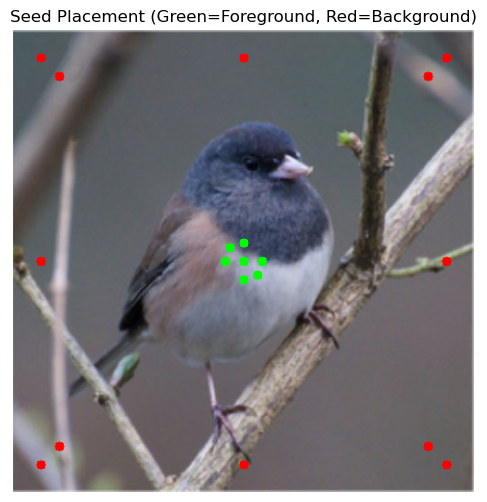

In [10]:
seed_vis = bird_img.copy()

for seed in fg_seeds:
    cv2.circle(seed_vis, tuple(seed), 5, (0, 255, 0), -1)

for seed in bg_seeds:
    cv2.circle(seed_vis, tuple(seed), 5, (0, 0, 255), -1)

cv2.imwrite('outputs/bird_seeds.jpg', seed_vis)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(seed_vis, cv2.COLOR_BGR2RGB))
plt.title('Seed Placement (Green=Foreground, Red=Background)')
plt.axis('off')
plt.show()

## 2.4 Experiment with Different Smoothness Weights

In [11]:
weights = [1.0, 10.0, 50.0]
segmentations = {}

print("Processing segmentation with different smoothness weights...")

for weight in weights:
    print(f"  Processing λ = {weight}...")
    gc = GraphCutSegmentation(bird_img, smoothness_weight=weight)
    seg = gc.segment(fg_seeds, bg_seeds)
    segmentations[weight] = seg
    cv2.imwrite(f'outputs/bird_segmentation_weight_{weight}.jpg', seg)

print("✓ All segmentations completed")

Processing segmentation with different smoothness weights...
  Processing λ = 1.0...
  Processing λ = 10.0...
  Processing λ = 10.0...
  Processing λ = 50.0...
  Processing λ = 50.0...
✓ All segmentations completed
✓ All segmentations completed


## 2.5 Visualize Smoothness Comparison

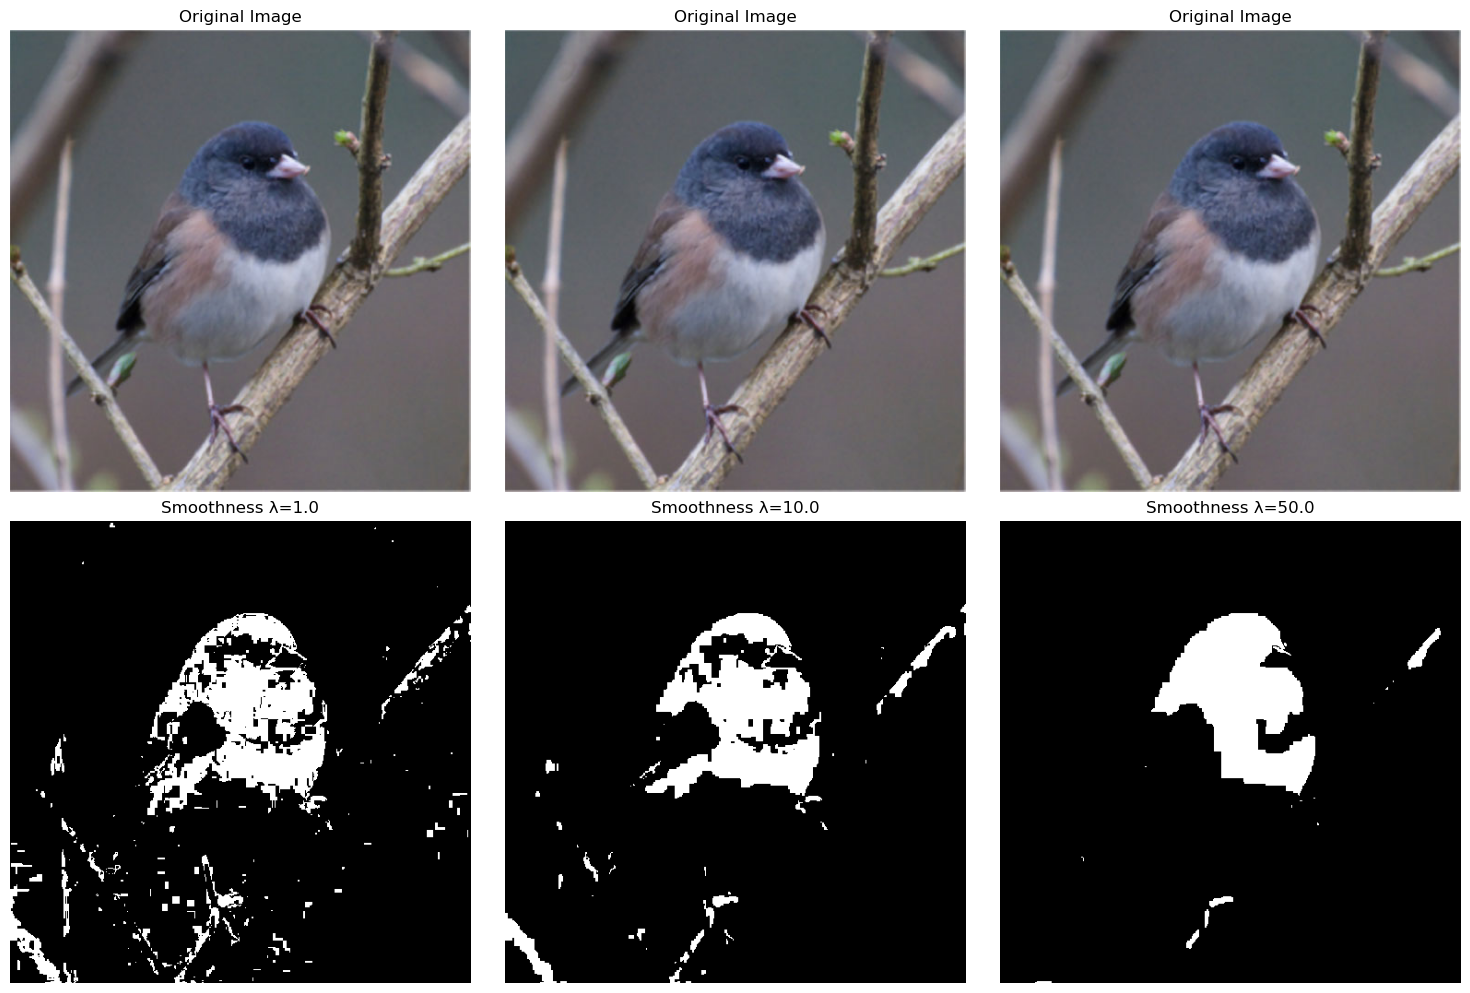

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for idx, weight in enumerate(weights):
    axes[0, idx].imshow(cv2.cvtColor(bird_img, cv2.COLOR_BGR2RGB))
    axes[0, idx].set_title(f'Original Image')
    axes[0, idx].axis('off')
    
    axes[1, idx].imshow(segmentations[weight], cmap='gray')
    axes[1, idx].set_title(f'Smoothness λ={weight}')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.savefig('outputs/bird_smoothness_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 2.6 Display Individual Segmentation Results

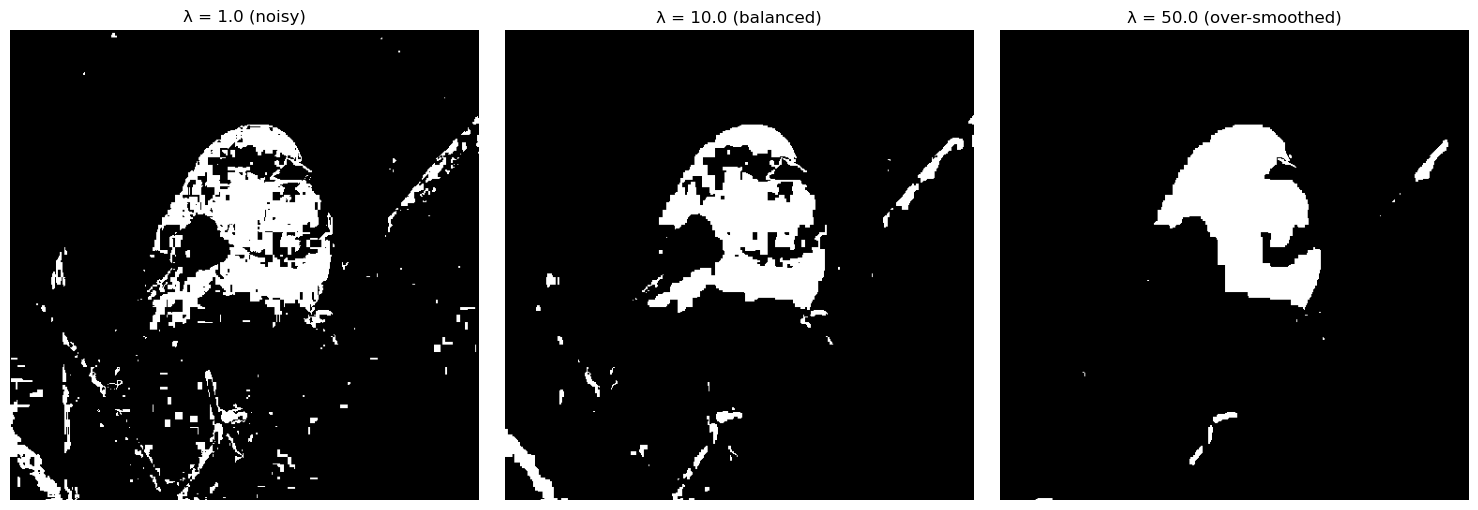

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(segmentations[1.0], cmap='gray')
axes[0].set_title('λ = 1.0 (noisy)')
axes[0].axis('off')

axes[1].imshow(segmentations[10.0], cmap='gray')
axes[1].set_title('λ = 10.0 (balanced)')
axes[1].axis('off')

axes[2].imshow(segmentations[50.0], cmap='gray')
axes[2].set_title('λ = 50.0 (over-smoothed)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 2.7 Create Final Segmentation Overlay

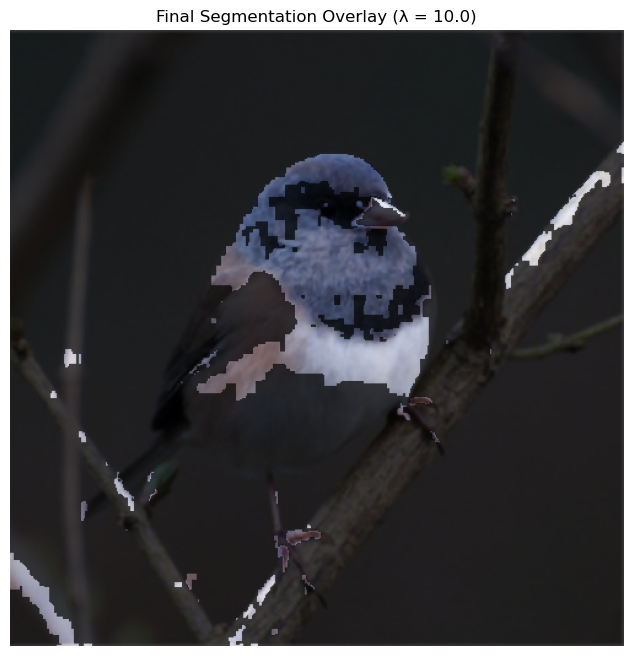

✓ Question 2 completed successfully!


In [14]:
final_seg = segmentations[10.0]
overlay = bird_img.copy()
overlay[final_seg == 0] = overlay[final_seg == 0] * 0.3

cv2.imwrite('outputs/bird_final_overlay.jpg', overlay)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title('Final Segmentation Overlay (λ = 10.0)')
plt.axis('off')
plt.show()

print("✓ Question 2 completed successfully!")